# Morpheus

In this notebook we show how to interface pyABC with the [Morpheus](https://morpheus.gitlab.io/) toolbox.

In [16]:
import pyabc
import pyabc.external
import scipy as sp
import numpy as np
import os
import tempfile
%matplotlib inline
import matplotlib.pyplot as plt

A Morpheus model is created by passing a Morpheus XML file to the ``pyabc.external.MorpheusModel`` class.

In [19]:
file_ = "/home/yannik/morpheus/Examples/ODE/MAPK_SBML.xml"
model = pyabc.external.MorpheusModel(file_)

Let us generate some dummy observed data. Therefore, we sample from true parameters. The returned value contains a link to a folder which has been newly created to accommodate all simulation files. By default, that folder is in the system's temporary folders, but that can also be customized.

The paramters we define here must correspond to Constants in the Morpheus XML file.

In [20]:
true_pars = {'V1': 2.5, 'V2': 0.25, 'k3': 0.025, 'k4': 0.025}
limits = {key: (0.5 * val, 2 * val) for key, val in true_pars.items()}

# generate data
observed_data = model.sample(true_pars)

As usual, we have to define a prior for our parameters. Also, we have to define a distance which computes a 1-dim value from the generated data. Note that also this step can be customized, e.g. for arbitrary summary statistics.

In [21]:
prior = pyabc.Distribution(**{key: pyabc.RV("uniform", lb, ub - lb)
                              for key, (lb, ub) in limits.items()})

def distance(data1, data2):
    df1 = pyabc.external.MorpheusData()(data1)
    df2 = pyabc.external.MorpheusData()(data2)
    d = np.sum(np.abs(df1['MAPK'] - df2['MAPK']))
    return d

Now, we are able to run our ABC analysis as usual. The ``pyabc.external`` classes take care of all calls to the external simulator.

In [4]:
abc = pyabc.ABCSMC(model, prior, distance, population_size=50)
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "test.db")
history = abc.new(db_path, observed_data)

INFO:History:Start <ABCSMC(id=1, start_time=2019-06-17 10:28:04.896768, end_time=None)>


In [5]:
abc.run(max_nr_populations=10)

INFO:Epsilon:initial epsilon is 73191.27640244998
INFO:ABC:t:0 eps:73191.27640244998
INFO:ABC:t:1 eps:51119.332612599974
INFO:ABC:t:2 eps:37721.19690325406
INFO:ABC:t:3 eps:27201.29389677095
INFO:ABC:t:4 eps:17741.386739451107
INFO:ABC:t:5 eps:13127.440997037056
INFO:ABC:t:6 eps:9718.399740666679
INFO:ABC:t:7 eps:7231.836762025014
INFO:ABC:t:8 eps:5570.923823079641
INFO:ABC:t:9 eps:4547.21938773589
INFO:History:Done <ABCSMC(id=1, start_time=2019-06-17 10:28:04.896768, end_time=2019-06-17 10:50:50.817745)>


We can also plot some results to see what ABC did.

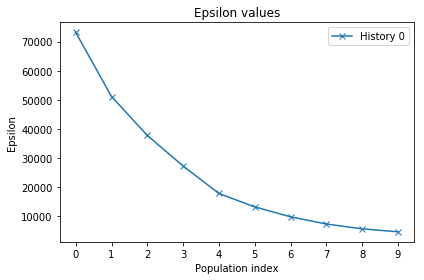

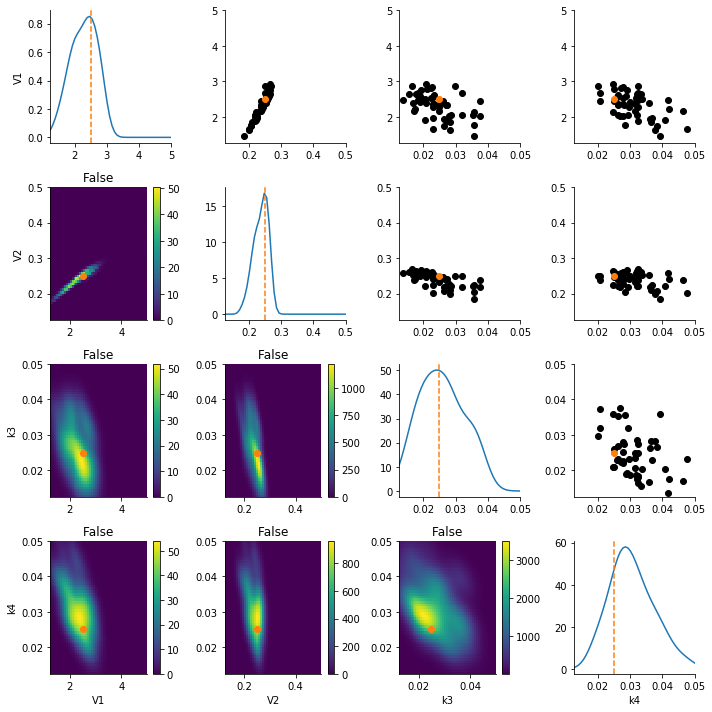

In [22]:
h = pyabc.History(db_path)
pyabc.visualization.plot_epsilons(h)
df, w = h.get_distribution(t=h.max_t)
pyabc.visualization.plot_kde_matrix(df, w, limits=limits, refval=true_pars)
plt.show()